Using device: cuda
Loaded 7 training graphs.


/tmp/ipykernel_405663/2884074438.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


[Epoch 1/70] Loss: 0.0989
[Epoch 2/70] Loss: 0.0857
[Epoch 3/70] Loss: 0.0737
[Epoch 4/70] Loss: 0.0621
[Epoch 5/70] Loss: 0.0522
[Epoch 6/70] Loss: 0.0442
[Epoch 7/70] Loss: 0.0399
[Epoch 8/70] Loss: 0.0366
[Epoch 9/70] Loss: 0.0367
[Epoch 10/70] Loss: 0.0354
[Epoch 11/70] Loss: 0.0349
[Epoch 12/70] Loss: 0.0336
[Epoch 13/70] Loss: 0.0350
[Epoch 14/70] Loss: 0.0355
[Epoch 15/70] Loss: 0.0365
[Epoch 16/70] Loss: 0.0352
[Epoch 17/70] Loss: 0.0404
[Epoch 18/70] Loss: 0.0427
[Epoch 19/70] Loss: 0.0343
[Epoch 20/70] Loss: 0.0331
[Epoch 21/70] Loss: 0.0314
[Epoch 22/70] Loss: 0.0867
[Epoch 23/70] Loss: 0.0541
[Epoch 24/70] Loss: 0.0521
[Epoch 25/70] Loss: 0.0470
[Epoch 26/70] Loss: 0.0436
[Epoch 27/70] Loss: 0.0376
[Epoch 28/70] Loss: 0.0374
[Epoch 29/70] Loss: 0.0368
[Epoch 30/70] Loss: 0.0356
[Epoch 31/70] Loss: 0.0356
[Epoch 32/70] Loss: 0.0350
[Epoch 33/70] Loss: 0.0342
[Epoch 34/70] Loss: 0.0346
[Epoch 35/70] Loss: 0.0338
[Epoch 36/70] Loss: 0.0339
[Epoch 37/70] Loss: 0.0328
[Epoch 38/

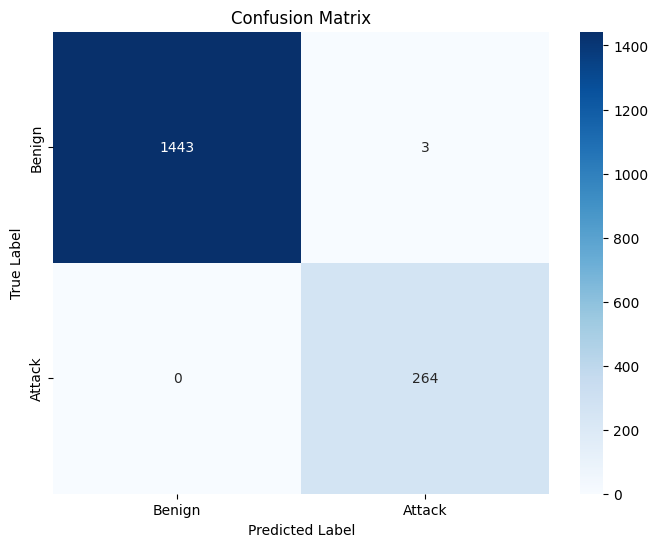

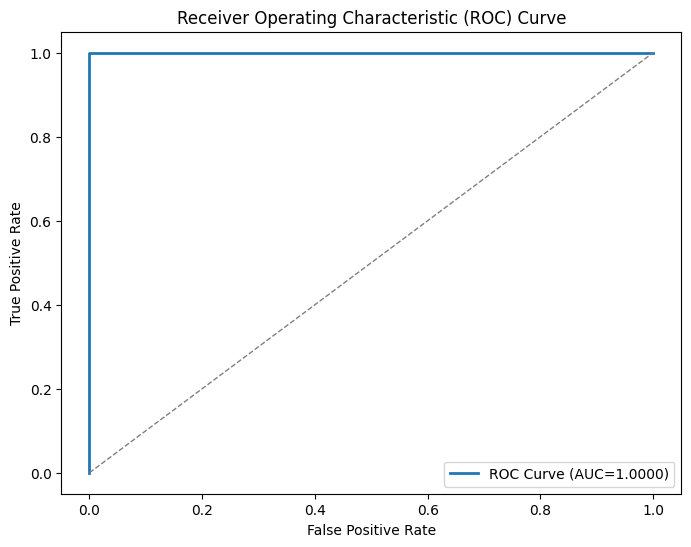

In [71]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv
from sklearn.metrics import (
    roc_auc_score, 
    precision_recall_fscore_support, 
    accuracy_score,
    confusion_matrix,
    roc_curve
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#######################
# 1) HeteroEdgeClassifier Model
#######################
class HeteroEdgeClassifier(nn.Module):
    def __init__(self, hidden_channels=64, out_channels=32, num_classes=2):
        super().__init__()

        self.conv1 = HeteroConv({
 #selected fetures
        }, aggr='sum')
        self.bn1_ip = nn.BatchNorm1d(hidden_channels)

        self.conv2 = HeteroConv({
 #selected fetures
        }, aggr='sum')
        self.bn2_ip = nn.BatchNorm1d(hidden_channels)

        self.lin_node = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_channels * 2, out_channels),
            nn.ReLU()
        )

        self.lin_edge = nn.Sequential(
            nn.Linear(out_channels * 2, out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(out_channels, out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(out_channels, num_classes)
        )

    def forward(self, data):
        x_dict = self.conv1(data.x_dict, data.edge_index_dict)
        x_dict['ip'] = self.bn1_ip(x_dict['ip'])
        x_dict['ip'] = F.relu(x_dict['ip'])

        x_dict = self.conv2(x_dict, data.edge_index_dict)
        x_dict['ip'] = self.bn2_ip(x_dict['ip'])
        x_dict['ip'] = F.relu(x_dict['ip'])

        x_dict['ip'] = self.lin_node(x_dict['ip'])
        return x_dict

    def edge_classify(self, z_src, z_dst):
        z_cat = torch.cat([z_src, z_dst], dim=-1)
        logits = self.lin_edge(z_cat)
        return logits

##############################
# 2) Focal Loss
##############################
def focal_loss(logits, targets, alpha=0.25, gamma=2.0):
    ce_loss = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    return (alpha * (1 - pt)**gamma * ce_loss).mean()

##############################
# 3) Train Edge Classifier
##############################
def train_edge_classifier(model, graphs, epochs=10, device='cuda', alpha=0.25, gamma=2.0):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for data in graphs:
            data = data.to(device)
            optimizer.zero_grad()

            x_dict = model(data)
            z_ip = x_dict['ip']

            loss_graph = 0.0
            for rel_type in data.edge_types:
                if 'edge_label' not in data[rel_type]:
                    continue
                labels = data[rel_type].edge_label
                if labels.numel() == 0:
                    continue

                edge_index = data[rel_type].edge_index
                src, dst = edge_index
                logits = model.edge_classify(z_ip[src], z_ip[dst])

                loss_rel = focal_loss(logits, labels, alpha=alpha, gamma=gamma)
                loss_graph += loss_rel

            loss_graph.backward()
            optimizer.step()
            total_loss += loss_graph.item()

        avg_loss = total_loss / len(graphs)
        print(f"[Epoch {epoch}/{epochs}] Loss: {avg_loss:.4f}")

################################
# 4) Evaluate Edge Classifier
################################
@torch.no_grad()
def evaluate_edge_classifier(model, test_graphs, device='cuda', threshold=0.5):
    model.eval()
    model.to(device)

    all_scores = []
    all_labels = []

    for data in test_graphs:
        data = data.to(device)
        x_dict = model(data)
        z_ip = x_dict['ip']

        for rel_type in data.edge_types:
            if 'edge_label' not in data[rel_type]:
                continue
            labels = data[rel_type].edge_label
            if labels.numel() == 0:
                continue

            edge_index = data[rel_type].edge_index
            src, dst = edge_index
            logits = model.edge_classify(z_ip[src], z_ip[dst])

            probs = F.softmax(logits, dim=-1)[:, 1]
            all_scores.extend(probs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    if len(np.unique(all_labels)) < 2:
        print("Only one class in test set => AUC=0.5 by definition.")
        return

    auc = roc_auc_score(all_labels, all_scores)
    final_preds = (all_scores > threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, final_preds, average='binary', zero_division=0
    )
    accuracy = accuracy_score(all_labels, final_preds)
    cm = confusion_matrix(all_labels, final_preds)

    print(f"AUC={auc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, Accuracy={accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.4f})", lw=2)
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    plt.show()

###############################
# 5) Data-Loading Helpers
###############################
def load_single_graph(directory, filename):
    path = os.path.join(directory, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found.")

    data = torch.load(path)

    for rel_type in data.edge_types:
        if 'edge_label' in data[rel_type]:
            lbl = data[rel_type].edge_label
            lbl = torch.where(lbl < 0, torch.tensor(0, device=lbl.device), lbl)
            lbl = torch.where(lbl > 1, torch.tensor(1, device=lbl.device), lbl)
            data[rel_type].edge_label = lbl

    return data

#########################
# 6) Main Script
#########################
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    train_dir = "3ed_trai_h_graphs_hetero_graphs"
    train_files = [f for f in os.listdir(train_dir) if f.endswith('.pt')]
    train_graphs = [load_single_graph(train_dir, f) for f in train_files]

    print(f"Loaded {len(train_graphs)} training graphs.")

    hidden_channels = 64
    out_channels = 32
    model = HeteroEdgeClassifier(hidden_channels, out_channels)

    train_edge_classifier(model, train_graphs, epochs=70, device=device)

    test_dir = "3ed_tes_h_graphs_hetero_graphs"
    test_files = [f for f in os.listdir(test_dir) if f.endswith('.pt')]
    test_graphs = [load_single_graph(test_dir, f) for f in test_files]

    print(f"Loaded {len(test_graphs)} test graph(s).")

    best_threshold = 0.43
    evaluate_edge_classifier(model, test_graphs, device=device, threshold=best_threshold)
